# Convolutional Neural Network

O nosso segundo modelo a ser implementado é uma Convolutional Neural Network.<br>
Este tipo de FNN tem um formato diferente da MLP que desenvolvemos no passo anterior. Após receber o input, este modelo vai aplicar operações convulsionais aos dados na convultional layer, sendo estes dados processados passados à função de ativação que, por sua vez, entrega os resultados a uma pooling layer, onde as dimensões espaciais são reduzidas. Depois de repetir este processo diversas vezes, os dados finais são passados a uma fully conected (dense) layer, como as que encontramos presentes no nosso MLP. Por fim, os dados chegam à output layer, onde obtemos as nossas previsões.

Este notebook está dividido nas seguinte partes:
- 0. Libraries
- 1. Notas Iniciais
- 2. Preparação do Audio, Extração, Pre-Processamento e Checkpoint
- 3. Criação do Modelo
- 4. 10-Fold Cross Validation e Hypertuning
- 5. Análise dos Resultados
- 6. Conclusões

# 

# 0. Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import librosa as lr
import pickle

import keras
import tensorflow as tf
from keras import optimizers
from keras import regularizers
from keras import models, layers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization, concatenate, LeakyReLU

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2024-12-02 19:30:23.763565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 19:30:23.770156: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 19:30:23.844974: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 19:30:23.914478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733167823.981299    2383 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733167824.00

# 

# 1. Notas Inicias

Mencionado previamente no primeiro notebook, este modelo é tipicamente usado para manuseamento de dados em 2D, sendo capaz de detetar hierarquias espaciais graças aos seus filtros convulsionais (kernels) combinados com o pooling.<br>
Tendo sido este o modelo desenvolvido por último, as escolhas que tinhamos de tomar foram facilitadas devido à experiência que reunímos durante a implementação do primeiro modelo.

Achamos por bem, de modo a podermos comparar a performance dos dois modelos de forma justa, utilizar os mesmos features para ambos os modelos. A única diferença será o modo que estes estão organizados.<br>
Enquanto que para o MLP utilizamos as médias dos valores do Mel Spectrogram e do Chromagram, neste modelo utilizaremos a totalidade destas extrações, ou seja, extrações 2D.<br>
Optamos também pelo stack das Spectral Features, criando uma nova feature 2D.

Assim, tendo as features já definidas, a estrutura deste modelo estava "predestinada" e só houve uma versão deste modelo, que é a apresentada neste notebook. Não obstante, o desenvolvimento deste modelo não foi tornado fácil por esta observação!

O input deste modelo final é, portanto, constituido por 3 features, todas elas bidimensionais! Temos:
- Mel Spectrogram;
- Chromagram;
- Spectral Features (unidimensionais stacked).

# 

# 2. Preparação do Audio, Extração, Pre-Processamento e Checkpoint

Este processo será semelhante ao que se encontra implementado neste mesmo passo do modelo MLP. A única alteração é a não realização da média dos valores do melspectrogram e do chromagram. Como referência, temos o seguinte texto (igual ao notebook anterior)!<br>
Nota - neste tipo de modelo, esta uniformização serve como zero padding.

O nosso modelo tem de receber como input uma série de arrays com tamanho fixo. Ora aqui nos deparamos com o nosso primeiro problema. Tal como mencionado no ponto 3.1 do PDF das direções para o projeto, os ficheiros de audio podem ter durações e sampling rates (quantidade de audio samples capturadas por segundo) diferentes. Isto significa que, para audio diferentes, as mesmas extrações vão ter tamanhos diferentes. De forma a combater este problema iremos, neste passo, realizar a **uniformização** destes aspetos!<br>

Para duração do audio iremos utilizar um **tamanho fixo de 4 segundos**. Audios com duração menor serão padded com zeros, enquanto que audios com maior duração serão truncados.
Quanto à sampling rate, poderiamos escolher valores como 16000Hz (qualidade comum), 22050Hz (qualidade melhorada) ou 44100Hz (CD-Quality). Uma vez que a maioria dos ficheiros têm uma **sample rate de 22050HZ**, e esta é a qualidade com maior fidelidade, optaremos por esta sampling rate.

Temos mais uns valores que convém fixar!<br>
A window length representa o número de audio samples analisadas de cada vez, e fixamos um valor de 507 samples (23ms).<br>
A hop length representa quanto a window lentgh se move após cada step, e foi fixado um valor de 276 samples (12.5ms). Este valor, menor que a window length, permite um ligeiro overlap de samples, resultando numa melhor resolução e melhor análise. Ótimo!<br>
Por fim, quanto ao número de pontos usados no Fast Fourier Transform define a resolução dos espectrogramas (no nosso caso, Mel-Spectrogram). Fixamos este valor a 2¹⁰ (1024), tornando esta extração bem definida mas não demasiado custosa.

Falando agora do nosso método de extração. Iremos começar por iterar por cada fold e, dentro de cada iteração, iteraremos também por cada ficheiro de audio. Para cada ficheiro iremos proceder à uniformização mencionada em cima, seguido da extração das features e consequente normalização! Segue-se a criação de um dicionário para cada audio, que guarda a fold a que pertence, as suas features, e a sua classe. Este dicionário é adicionado a uma lista que, no fim de todas as extrações, é transformado em DataFrame. O nosso último passo é o one hot encoding das labels, transformando um número categórico (de 0 a 9) num array (também de 0 a 9)!

É de **extrema importância** salientar que este processo é **muito demorado** e **computacionalmente dispendioso**.<br>
De modo a não ter de fazer a extração das features sempre que queremos trabalhar neste notebook, optamos por guardar o dataframe em formato pickle, estabelecendo assim um "checkpoint"! Assim, antes de realizar a extração, será verificada a existência do dataframe no diretório atual. Este será loaded se existir, caso contrário, realizar-se-á a extração!

In [2]:
#definir path do ficheiro com metadata
metadata_path = "/home/miguel/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv"
metadata_df = pd.read_csv(metadata_path)

#definir localizacao da pasta que contem os folds com os ficheiros audio
dir_folds = "/home/miguel/sound_datasets/urbansound8k/audio"

In [3]:
#lista para guardar o nosso dataframe
dados = []

#lista com o nome das pastas dos folds
folds = [fold for fold in os.listdir(dir_folds) if "fold" in fold]

#definicao do nosso normalizador
scaler = MinMaxScaler()

In [4]:
#se a extração já foi feita
if os.path.exists(os.path.join(os.getcwd(), "extracoes_cnn.pkl")):
    
    #abrir o dataframe em formato pickle
    with open(os.path.join(os.getcwd(), "extracoes_cnn.pkl"), "rb") as ficheiro:
        dados = pickle.load(ficheiro)
    ficheiro.close()
    
    
    
#se ainda não foi feita extração   
else:
    
    #para cada fold
    for fold in folds:
    
        #determinar o path de cada audio na fold
        audio_files = lr.util.find_files(os.path.join(dir_folds,fold))

        #para cada audio da fold
        for audio in audio_files:
            
            #obter a sua classe
            classid = metadata_df[metadata_df["slice_file_name"]==audio.split('/')[-1]]["classID"].values[0]

            #obter o audio e sample rate
            y, sample_rate = lr.load(audio, sr=None)
            
            #resample do audio com a sample rate definida 
            y = lr.resample(y, orig_sr=sample_rate, target_sr=22050)

            #caso a duracao seja menor que a definida, adicionar silencio no fim
            if len(y) < 4*22050:
                y = np.concatenate([y, np.zeros(shape=(4*22050 - len(y),))])
            #caso a duracao seja maior que a definida, truncar o audio
            elif len(y) > 4*22050:
                y = y[:4*22050]

            #extrair Mel-Spectrogram com os valores definidos, fazendo a sua média
            melspectrogram = lr.feature.melspectrogram(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            melspectrogram = lr.power_to_db(melspectrogram, ref=np.max)
            melspectrogram = scaler.fit_transform(melspectrogram)

            #extrair Chromagram com os valores definidos, fazendo a sua média
            chromagram = lr.feature.chroma_stft(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023), n_chroma=121)
            chromagram = scaler.fit_transform(chromagram)

            #extrair Spectral Centroid com os valores definidos
            centroid = lr.feature.spectral_centroid(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            centroid = scaler.fit_transform(centroid)
            
            #extrair Spectral Bandwidth com os valores definidos
            bandwidth = lr.feature.spectral_bandwidth(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            bandwidth = scaler.fit_transform(bandwidth)

            #extrair Spectral Flagtness com os valores definidos
            flatness = lr.feature.spectral_flatness(y=y, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            flatness = scaler.fit_transform(flatness)
            
            #extrair Spectral Rolloff com os valores definidos
            rolloff = lr.feature.spectral_rolloff(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            rolloff = scaler.fit_transform(rolloff)
            
            #dicionario com as extracoes do audio
            extract = {"fold": fold, "melspectrogram": melspectrogram, "chromagram": chromagram , "spectral_centroid": centroid, "spectral_bandwidth": bandwidth, "spectral_flatness": flatness, "spectral_rolloff": rolloff, "label": int(classid)}

            #juntar extracoes do audio à lista de extracoes totais
            dados.append(extract)
        
    #transformar lista em dataframe
    dados = pd.DataFrame(dados, columns=["fold", "melspectrogram", "chromagram", "spectral_centroid", "spectral_bandwidth", "spectral_flatness", "spectral_rolloff", "label"])

    #one hot encoding das labels
    encoded_labels = np.zeros(shape=(dados['label'].size, dados['label'].max()+1))
    encoded_labels[np.arange(dados['label'].size),dados['label'].to_numpy(dtype=np.int16)] = 1
    dados['label'] = encoded_labels.tolist()
    dados['label'].apply(np.array)

    #guardar ficheiro (checkpoint :3)
    with open(os.path.join(os.getcwd(), "extracoes_cnn.pkl"), "wb") as ficheiro:
        pickle.dump(dados, ficheiro)
    ficheiro.close()

In [5]:
dados.head()

,fold,melspectrogram,chromagram,spectral_centroid,spectral_bandwidth,spectral_flatness,spectral_rolloff,label
0,fold4,"[[0.546864440953826, 0.8467147162202673, 0.702...","[[0.07489772872557778, 0.14160390482372515, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,fold4,"[[0.97086054, 0.85777146, 0.7646646, 0.7734859...","[[0.060302958, 0.31506267, 0.6121784, 0.321119...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,fold4,"[[0.58306813, 0.58243966, 0.5393404, 0.6189806...","[[0.035384495, 0.006779304, 0.0115724355, 0.00...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,fold4,"[[0.55674535, 0.4507053, 0.5976187, 0.59682417...","[[0.038185842, 0.0014415213, 0.010856678, 0.01...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,fold4,"[[0.9794446, 0.9999999, 0.99977255, 0.9862357,...","[[0.9577345, 0.8270682, 0.11605942, 0.14695123...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 

# 3. Criação do Modelo

Vamos agora criar a nossa CNN.<br>
Temos:

- **Input Layer**: a nossa primeira camada é constituída por 3 inputs de duas dimensões cada. O primeiro input é o melspectrogram e tem shape (128,320), o segundo input é o chromagram e tem shape (121, 320), o último input é a junção das spectral features e tem shape (4,320).


- **Hidden Layers**: tal como no nosso primeiro modelo, após vários testes definimos certos valores fixos. Temos um valor de 20% de **_dropout_** constante (prevenindo overfit através da "desativação" dd 20% dos neurónios de cada camada); o **_padding_** foi estabelecido como Same (obrigandiovo output a ter as mesmas dimensões que o input, garantindo uniformidade); definimos a **_função de ativação_** ReLU (uma versão mais simpled do LeakyReLU usada no MLP); o nosso **_kernel initializer_** é sempre He Normal (desenhado para uso com ReLU); e por fim temos o valor 0.05 de **_L2 regularization_** tal como no modelo anterior, desta vez aplicada aos kernels.<br>Para cada tipo de input, logicamente, desenvolvemos um modo de processamento diferente.<br>Para o **_melspectrogram e chromagram implementamos processamentos iguais_**, uma vez que são features semelhantes.A **_primeira camada_** é uma camada **_convolucional de kernels 2D_**, com **_16 filtros_** e um **_kernel size de 7_** (as **_strides variam_**, sendo 3 para os melspectrograms e 1 para o chromagram). Os dados desta layer são depois passados para **_MaxPooling2D_** onde a sua dimensão espacial é reduzida ao **_maior valor de uma shape (4,4)_**. Estes dados passam ainda por um **_dropout_**. Este **_processo repete-se mais 3 vezes para cada input_**, sendo  **_mudado o número de filtros (32, 64, 128)_** e o **_pool_size (3,3 ; 2,2 ; 2,2)_**.<br>Para as **_spectral features_**, as camadas convolucionais 2D são substituídas por **_camadas convolucionais 1D_**. Devido à sua menor dimensão, este processo é apenas **_executado 3 vezes_**, com **_valores semelhantes_** às camadas mencionadas anteriormente. Ao aplicar esta metodologia, garantimos uma **_diminuição na dimensão dos inputs, aplicando cada vez mais filtros!_**<br>No fim de todos estes processos, os **_resultados são "achatados" (flatten) e concatenados_**, passando por uma série de **_fully conected (dense) layers, com 512,256 e 128 neurónios_** respetivamente. O resultados destas camadas é, no fim, passado à output layer.


- **Output Layer**: esta camada tem os 10 neurónios finais, cada um representando uma classe. Usamos a activation function softmax (retorna a probabilidade do audio ser de cada uma das classes, e escolhe a classe com probabilidade mais elevada).

In [6]:
print(f"Shape Mel-Spectrogram: {dados.iloc[0,1].shape}")
print(f"Shape Chromagram: {dados.iloc[0,2].shape}")
print(f"Shape Spectral Centroid: {dados.iloc[0,3].shape}")
print(f"Shape Spectral Bandwidth: {dados.iloc[0,4].shape}")
print(f"Shape Spectral Flatness: {dados.iloc[0,5].shape}")
print(f"Shape Spectral Rolloff: {dados.iloc[0,6].shape}")

Shape Mel-Spectrogram: (128, 320)
Shape Chromagram: (121, 320)
Shape Spectral Centroid: (1, 320)
Shape Spectral Bandwidth: (1, 320)
Shape Spectral Flatness: (1, 320)
Shape Spectral Rolloff: (1, 320)


In [7]:
#dimensoes de cada input
dim_melspectrogram = (128,320, 1)
dim_chromagram = (121,320, 1)
dim_spectrals = (320,4)

In [8]:
def create_model():
    
    #definicao de 5 inputs diferentes
    input1 = Input(shape=dim_melspectrogram, name = 'melspectrogram')
    input2 = Input(shape=dim_chromagram, name = 'chromagram')
    input3 = Input(shape=dim_spectrals, name = 'spectrals')

    #processamento melspectrogram
    x1 = Conv2D(16,kernel_size=7,strides=3,padding = "same",activation="relu", kernel_initializer='he_normal')(input1)
    x1 = MaxPooling2D(padding='same',pool_size=(4,4))(x1)
    x1 = Dropout(0.4)(x1)
    x1 = Conv2D(32,kernel_size=5,strides=1,padding = "same",activation="relu", kernel_initializer='he_normal')(x1)
    x1 = MaxPooling2D(padding='same',pool_size=(3,3))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Conv2D(64,kernel_size=3,strides=1,padding = "same", activation="relu", kernel_initializer='he_normal')(x1)
    x1 = MaxPooling2D(padding='same',pool_size=(2,2))(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Conv2D(128,kernel_size=3,strides=1,padding = "same",activation="relu", kernel_initializer='he_normal')(x1)
    x1 = MaxPooling2D(padding='same',pool_size=(2,2))(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Flatten()(x1)
    
    #processamento chromagram
    x2 = Conv2D(16,kernel_size=5,strides=1,activation="relu", kernel_initializer='he_normal')(input2)
    x2 = MaxPooling2D(padding='same',pool_size=(4,4))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Conv2D(32,kernel_size=5,strides=1,activation="relu", kernel_initializer='he_normal')(x2)
    x2 = MaxPooling2D(padding='same',pool_size=(3,3))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Conv2D(64,kernel_size=3,strides=1,activation="relu", kernel_initializer='he_normal')(x2)
    x2 = MaxPooling2D(padding='same',pool_size=(2,2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Conv2D(128,kernel_size=3,strides=1,activation="relu", kernel_initializer='he_normal')(x2)
    x2 = MaxPooling2D(padding='same',pool_size=(2,2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    
    #processamento spectrals
    x3 = Conv1D(16,kernel_size=5,strides=1,activation="relu")(input3)
    x3 = MaxPooling1D(padding='same',pool_size=(2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Conv1D(32,kernel_size=3,strides=1,activation="relu")(x3)
    x3 = MaxPooling1D(pool_size=(2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Conv1D(64,kernel_size=3,strides=1,activation="relu")(x3)
    x3 = Flatten()(x3) 

    
    
    #concatenacao de todos os inputs processados
    merged = concatenate([x1, x2, x3])
    
    #camadas finais após concatenação
    fc = Dense(512,activation="relu", kernel_regularizer = regularizers.l2(0.05), kernel_initializer='he_normal')(merged)
    fc = Dropout(0.2)(fc)
    fc = Dense(256,activation="relu", kernel_regularizer = regularizers.l2(0.05), kernel_initializer='he_normal')(fc)
    fc = Dropout(0.2)(fc)
    fc = Dense(128,activation="relu", kernel_regularizer = regularizers.l2(0.05), kernel_initializer='he_normal')(fc)

    
    #output
    output = Dense(10, activation='softmax')(fc)
    
    
    #definição do modelo
    model = keras.Model(inputs=[input1, input2, input3], outputs=output)

    
    #return
    return model

In [9]:
#criar modelo exemplar
model = create_model()

2024-12-02 19:30:30.011775: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
#sumário do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ melspectrogram      │ (None, 128, 320,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chromagram          │ (None, 121, 320,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 43, 107,   │        800 │ melspectrogram[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 117, 316,  │        416 │ chromagram[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 11, 27,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 30, 79,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 11, 27,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 79,    │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 27,    │     12,832 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 26, 75,    │     12,832 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 9, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 9, 25, 32) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectrals           │ (None, 320, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 9, 32)  │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 9, 25, 32) │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 316, 16)   │        336 │ spectrals[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 9, 64)  │     18,496 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 7, 23, 64) │     18,496 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,400,378 (12.97 MB)

 Trainable params: 3,400,378 (12.97 MB)

 Non-trainable params: 0 (0.00 B)

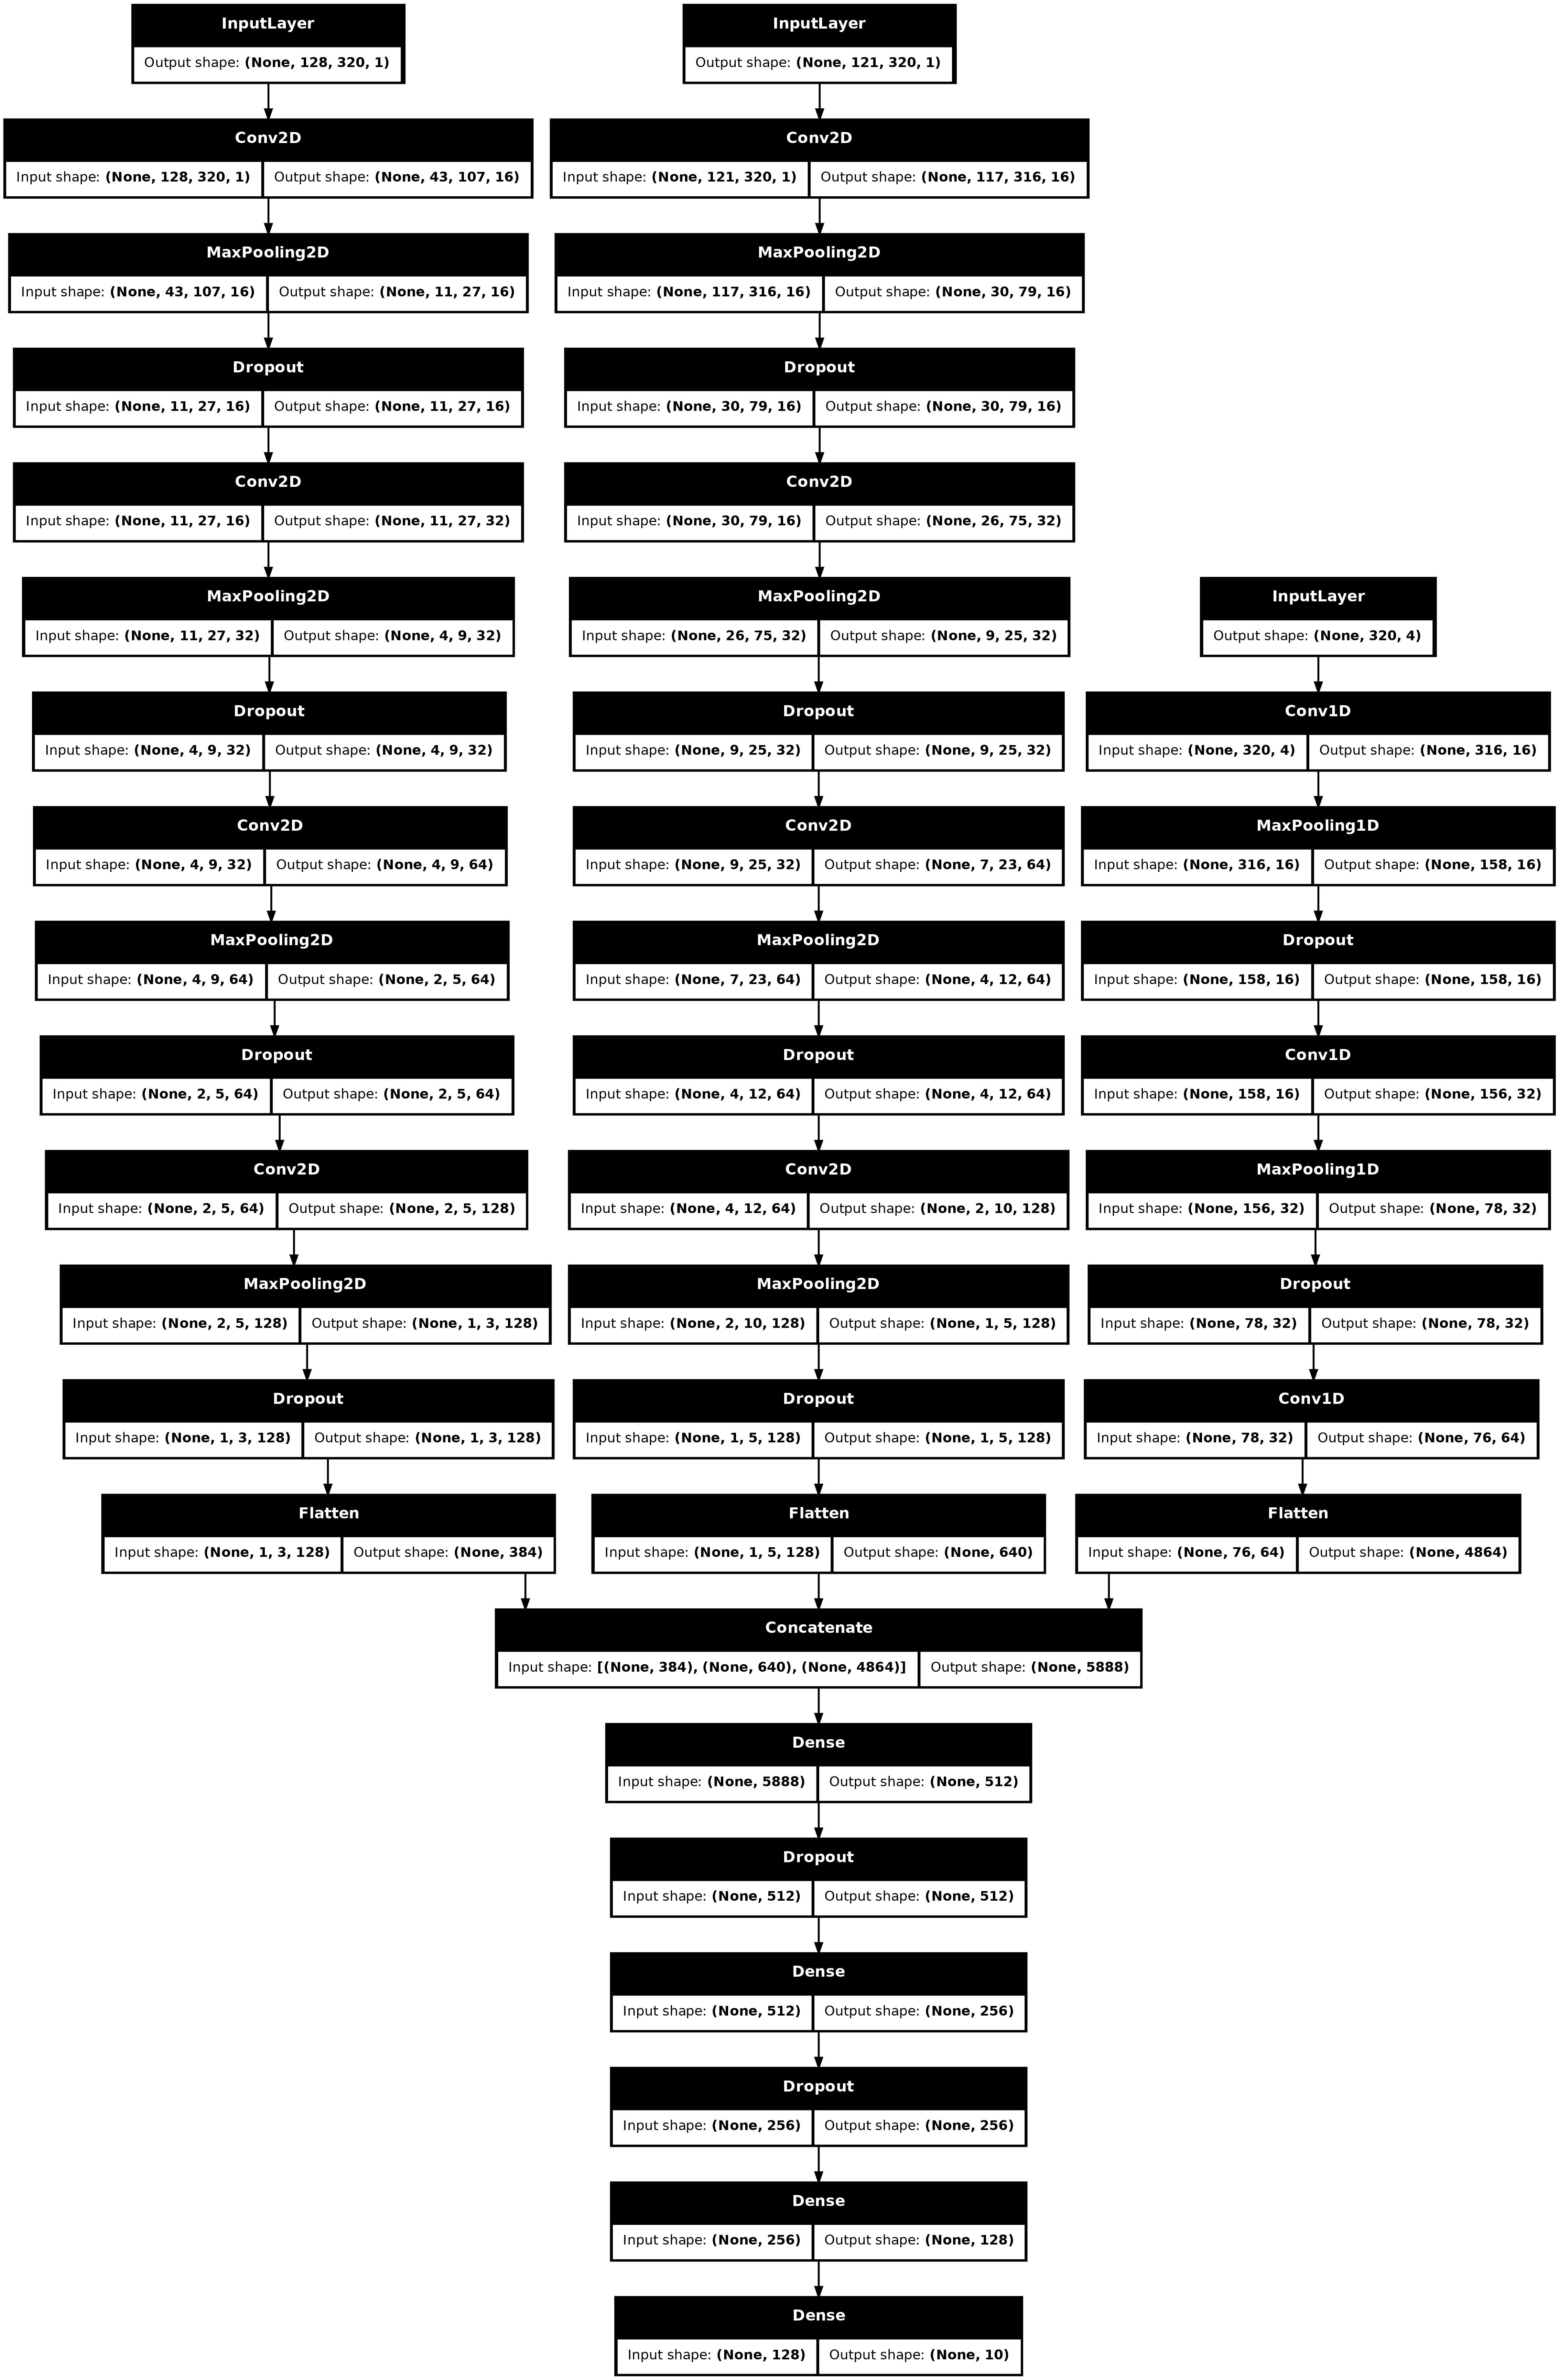

In [11]:
#esquema geral do modelo
keras.utils.plot_model(model, "model.png", show_shapes=True)

Resumindo o nosso modelo:<br>
- Pipelines separadas para cada input;
- Camadas convolucionais com número de filtros e kernel size adaptados às dimensões do input;
- MaxPooling adaptado às dimensões do input
- Função de ativação ReLU;
- Regularização com uso de Dropout constante a 20% e L2 a 0.05;
- Concatenação dos inputs depois de processados e achatados;
- Total de 3,400,378 parâmetros, dos quais 3,400,378 são treináveis (weights e biases) e 0 não são treináveis.

De um modo geral, temos um modelo complexo e prontíssimo para ser treinado :)

# 

# 4. 10-Fold Cross Validation

Chegou a hora de testar o nosso modelo!<br>
Iremos, para cada fold, usar a fold como test e as restantes como train e validação (20% do train). Vamos recolher informações sobre o comportmento do nosso modelo (accuracy, loss, previsoes, ...) para depois analisarmos o modelo no próximo passo.


Esta parte do trabaho serviu também para descobrir a melhor combinação de hiperparâmetros.<br>
Fizemos testes com:
- **Optimizer** (acabamos por selecionar o **adam**, que nos garantiu melhores resultados);
- **Learning Rate** (definida para **0.001** inicialmente, sendo depois adaptada pelo optimizer);
- **Epochs** (estabelecemos um número fixo de 50 epochs; a complexidade deste modelo não permite muitas mais epochs senão o kernel morre);
- **Early Stopping** (decidimos não implementar early stopping pois causava muitos problemas; o kernel não aguenta mais de 70 de epochs e a paragem prematura com pouca patient apresentava resultados não óptimos! Para este modelo não achámos necesário esta adição).

In [12]:
#lista para guardar as métricas
results = []

#faz crashar o treino hahaha, deixar comentado e não usar!! modelo muito intenso :)
#definir realy stopping (para quando a val loss nao melhora passado 50 epochs)
#early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)

#time_size
time_size = 4*22050//round(22050 * 0.0125)+1


#para cada fold
for i in range(1,11):
    
    
    
    #----------TRAIN, TEST, VALID----------
    
    
    fold = "fold"+str(i)
    
    X_test = dados[dados["fold"] == fold]
    y_test = X_test["label"]
    X_test = X_test.drop(columns=["fold", "label"])
    
    X_train = dados[dados["fold"] != fold]
    y_train = X_train["label"]
    X_train = X_train.drop(columns=["fold", "label"])

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    X_train_melspectrogram = np.asarray(X_train["melspectrogram"].to_list()).astype(np.float32)
    X_train_chromagram = np.asarray(X_train["chromagram"].to_list()).astype(np.float32)
    X_train_spectrals = np.stack([np.asarray(tuple(X_train["spectral_centroid"].to_list())).astype(np.float32),np.asarray(tuple(X_train["spectral_bandwidth"].to_list())).astype(np.float32),np.asarray(tuple(X_train["spectral_flatness"].to_list())).astype(np.float32),np.asarray(tuple(X_train["spectral_rolloff"].to_list())).astype(np.float32)], axis=-1).reshape(-1, time_size, 4)
    y_train = np.asarray(y_train.to_list()).astype(np.float32)
    
    X_val_melspectrogram = np.asarray(X_val["melspectrogram"].to_list()).astype(np.float32)
    X_val_chromagram = np.asarray(X_val["chromagram"].to_list()).astype(np.float32)
    X_val_spectrals = np.stack([np.asarray(tuple(X_val["spectral_centroid"].to_list())).astype(np.float32), np.asarray(tuple(X_val["spectral_bandwidth"].to_list())).astype(np.float32), np.asarray(tuple(X_val["spectral_flatness"].to_list())).astype(np.float32),np.asarray(tuple(X_val["spectral_rolloff"].to_list())).astype(np.float32)], axis=-1).reshape(-1, time_size, 4)
    y_val = np.asarray(y_val.to_list()).astype(np.float32)
    
    X_test_melspectrogram = np.asarray(X_test["melspectrogram"].to_list()).astype(np.float32)
    X_test_chromagram = np.asarray(X_test["chromagram"].to_list()).astype(np.float32)
    X_test_spectrals = np.stack([np.asarray(tuple(X_test["spectral_centroid"].to_list())).astype(np.float32),np.asarray(tuple(X_test["spectral_bandwidth"].to_list())).astype(np.float32), np.asarray(tuple(X_test["spectral_flatness"].to_list())).astype(np.float32), np.asarray(tuple(X_test["spectral_rolloff"].to_list())).astype(np.float32)], axis=-1).reshape(-1, time_size, 4) 
    y_test = np.asarray(y_test.to_list()).astype(np.float32)

    
    
    del X_train, X_val, X_test

    
    
    #----------MODELO----------
    
    
    
    #iniciar cronometro de treino
    inicio = time.time()
    
    #criar o modelo
    model = create_model()

    #definir o optimizer e learning rate
    adam = optimizers.Adam(0.001)
    
    #compilar o modelo
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"] )

    #fit do modelo aos dados atuais
    history = model.fit({'melspectrogram': X_train_melspectrogram, 'chromagram': X_train_chromagram, 'spectrals': X_train_spectrals}, y_train, epochs=50, batch_size = 32, validation_data=({'melspectrogram': X_val_melspectrogram, 'chromagram': X_val_chromagram, 'spectrals': X_val_spectrals}, y_val))

    #calcular tempo de treino
    tempo = time.time() - inicio
    
    
    
    #----------METRICAS----------
    
    
    
    #avaliacao do modelo
    evaluation = model.evaluate(x={'melspectrogram': X_test_melspectrogram, 'chromagram': X_test_chromagram, 'spectrals': X_test_spectrals}, y=y_test)
    
    #obter previsoes, e reshape das previsoes e classes, para calcular confusion matrix
    y_pred = model.predict(x={'melspectrogram': X_test_melspectrogram, 'chromagram': X_test_chromagram, 'spectrals': X_test_spectrals})
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    #calcular confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    print()
    print("FOLD", i)
    print("FOLD ACCURACY:", evaluation[1])
    print("FOLD EPOCHS:", len(history.epoch))

    results.append({
        'fold': i,
        'time': tempo,
        'num_epochs': len(history.epoch),
        'train_loss': history.history.get('loss'),
        'train_accuracy': history.history.get('accuracy'),
        'val_loss': history.history.get('val_loss'),
        'val_accuracy': history.history.get('val_accuracy'),
        'test_loss': evaluation[0],
        'test_accuracy': evaluation[1],
        'confusion_matrix':cm,
    })

    
    
    #----------DELETE MODEL----------
    
    
    
    del model
    
    
    
    print("\n\n\n--------------------\n\n\n")

Epoch 1/50


/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.1303 - loss: 34.6953 - val_accuracy: 0.1978 - val_loss: 3.5834
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.2455 - loss: 2.8913 - val_accuracy: 0.3206 - val_loss: 2.0694
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3121 - loss: 2.0096 - val_accuracy: 0.3709 - val_loss: 1.8511
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3427 - loss: 1.8508 - val_accuracy: 0.3836 - val_loss: 1.8674
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.3686 - loss: 1.8034 - val_accuracy: 0.4046 - val_loss: 1.7304
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.4039 - loss: 1.7144 - val_accuracy: 0.4364 - val_loss: 1.6719
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.4130 - loss: 1.6918 - val_accuracy: 0.4580 - val_loss: 1.6611
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.4415 - loss: 1.6395 - val_accur

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1457 - loss: 35.4398 - val_accuracy: 0.3040 - val_loss: 3.8299
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.2904 - loss: 3.0123 - val_accuracy: 0.3556 - val_loss: 2.0609
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.3409 - loss: 2.0141 - val_accuracy: 0.3805 - val_loss: 1.8661
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.3606 - loss: 1.8524 - val_accuracy: 0.3244 - val_loss: 1.9218
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3663 - loss: 1.8200 - val_accuracy: 0.4098 - val_loss: 1.7352
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.4019 - loss: 1.7055 - val_accuracy: 0.3805 - val_loss: 1.7528
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.4117 - loss: 1.6842 - val_accuracy: 0.4512 - val_loss: 1.6401
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.4252 - loss: 1.6588 - val_accu

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.1507 - loss: 34.9943 - val_accuracy: 0.2029 - val_loss: 3.6322
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.1948 - loss: 2.9860 - val_accuracy: 0.2548 - val_loss: 2.1863
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.2501 - loss: 2.0885 - val_accuracy: 0.2971 - val_loss: 2.0003
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.2689 - loss: 2.0036 - val_accuracy: 0.3431 - val_loss: 1.8925
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.3345 - loss: 1.8750 - val_accuracy: 0.3630 - val_loss: 1.8728
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.3513 - loss: 1.8547 - val_accuracy: 0.4085 - val_loss: 1.7577
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.3641 - loss: 1.7625 - val_accuracy: 0.4187 - val_loss: 1.6905
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.3916 - loss: 1.6943 - val_acc

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1487 - loss: 34.1013 - val_accuracy: 0.2447 - val_loss: 3.2488
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.2392 - loss: 2.6536 - val_accuracy: 0.3396 - val_loss: 2.0524
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.3014 - loss: 1.9779 - val_accuracy: 0.3544 - val_loss: 1.9055
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.3407 - loss: 1.8580 - val_accuracy: 0.3906 - val_loss: 1.8174
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3642 - loss: 1.7705 - val_accuracy: 0.4106 - val_loss: 1.7557
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.3859 - loss: 1.7180 - val_accuracy: 0.4358 - val_loss: 1.6682
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.3943 - loss: 1.6786 - val_accuracy: 0.4403 - val_loss: 1.6298
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.4344 - loss: 1.5997 - val_accur

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1405 - loss: 33.9254 - val_accuracy: 0.2327 - val_loss: 3.2018
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.2916 - loss: 2.5875 - val_accuracy: 0.3244 - val_loss: 2.0632
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.3486 - loss: 1.9490 - val_accuracy: 0.3506 - val_loss: 1.9515
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.3714 - loss: 1.7857 - val_accuracy: 0.4026 - val_loss: 1.7632
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.3977 - loss: 1.7363 - val_accuracy: 0.3917 - val_loss: 1.7399
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.3979 - loss: 1.7028 - val_accuracy: 0.4250 - val_loss: 1.6894
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.4146 - loss: 1.6437 - val_accuracy: 0.4442 - val_loss: 1.6568
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.4538 - loss: 1.5870 - val_accu

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.1478 - loss: 33.0310 - val_accuracy: 0.2611 - val_loss: 2.9710
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.2417 - loss: 2.5075 - val_accuracy: 0.3856 - val_loss: 1.9794
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.3204 - loss: 1.9555 - val_accuracy: 0.3565 - val_loss: 1.9057
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.3580 - loss: 1.8357 - val_accuracy: 0.3748 - val_loss: 1.7850
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.3879 - loss: 1.7323 - val_accuracy: 0.4399 - val_loss: 1.6775
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.4006 - loss: 1.6512 - val_accuracy: 0.4463 - val_loss: 1.5878
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.4142 - loss: 1.6110 - val_accuracy: 0.4633 - val_loss: 1.5964
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.4464 - loss: 1.5791 - val_accura

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5706 - loss: 1.7090
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

FOLD 6
FOLD ACCURACY: 0.563791036605835
FOLD EPOCHS: 50



--------------------



Epoch 1/50


/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1398 - loss: 34.0579 - val_accuracy: 0.2274 - val_loss: 3.2814
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.2114 - loss: 2.7092 - val_accuracy: 0.3325 - val_loss: 1.9981
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3166 - loss: 1.9928 - val_accuracy: 0.3819 - val_loss: 1.8222
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3464 - loss: 1.8394 - val_accuracy: 0.3895 - val_loss: 1.7962
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3863 - loss: 1.7650 - val_accuracy: 0.3870 - val_loss: 1.8282
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3879 - loss: 1.7319 - val_accuracy: 0.4522 - val_loss: 1.6707
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3884 - loss: 1.7078 - val_accuracy: 0.4155 - val_loss: 1.6254
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.4130 - loss: 1.6468 - val_accura

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7249 - loss: 1.0926
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

FOLD 7
FOLD ACCURACY: 0.6957040429115295
FOLD EPOCHS: 50



--------------------



Epoch 1/50


/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.1285 - loss: 33.3244 - val_accuracy: 0.2327 - val_loss: 2.9904
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.2336 - loss: 2.5840 - val_accuracy: 0.3184 - val_loss: 1.9973
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.3180 - loss: 1.9492 - val_accuracy: 0.3796 - val_loss: 1.7737
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.3569 - loss: 1.8130 - val_accuracy: 0.3903 - val_loss: 1.8152
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.3877 - loss: 1.7564 - val_accuracy: 0.3682 - val_loss: 1.7744
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.3946 - loss: 1.7260 - val_accuracy: 0.4414 - val_loss: 1.6492
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.4408 - loss: 1.6252 - val_accuracy: 0.4508 - val_loss: 1.5980
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.4477 - loss: 1.5821 - val_accura

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5906 - loss: 1.7885
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

FOLD 8
FOLD ACCURACY: 0.6290322542190552
FOLD EPOCHS: 50



--------------------



Epoch 1/50


/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.1292 - loss: 35.7264 - val_accuracy: 0.2386 - val_loss: 4.0549
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.2442 - loss: 3.2045 - val_accuracy: 0.3213 - val_loss: 2.1780
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.3252 - loss: 2.0599 - val_accuracy: 0.3125 - val_loss: 1.9574
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3507 - loss: 1.8641 - val_accuracy: 0.4173 - val_loss: 1.7712
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.3748 - loss: 1.7818 - val_accuracy: 0.3996 - val_loss: 1.7989
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3932 - loss: 1.7102 - val_accuracy: 0.4072 - val_loss: 1.6936
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.4084 - loss: 1.6705 - val_accuracy: 0.4426 - val_loss: 1.6294
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.4302 - loss: 1.6119 - val_accura

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8170 - loss: 0.8861
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

FOLD 9
FOLD ACCURACY: 0.7083333134651184
FOLD EPOCHS: 50



--------------------



Epoch 1/50


/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectrals']. Received: the structure of inputs={'melspectrogram': '*', 'chromagram': '*', 'spectrals': '*'}
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.1350 - loss: 33.8296 - val_accuracy: 0.1932 - val_loss: 3.1282
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.2211 - loss: 2.6308 - val_accuracy: 0.2451 - val_loss: 2.1511
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.2694 - loss: 2.0183 - val_accuracy: 0.3116 - val_loss: 1.9290
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3138 - loss: 1.8664 - val_accuracy: 0.3344 - val_loss: 1.8188
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3237 - loss: 1.7847 - val_accuracy: 0.3908 - val_loss: 1.7410
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3733 - loss: 1.6929 - val_accuracy: 0.4047 - val_loss: 1.6750
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3719 - loss: 1.7059 - val_accuracy: 0.4376 - val_loss: 1.6532
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3891 - loss: 1.6460 - val_accura

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7521 - loss: 1.0641
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

FOLD 10
FOLD ACCURACY: 0.7120668888092041
FOLD EPOCHS: 50



--------------------





# 

# 6. Análise dos resultados

Agora temos de analisar a performance do nosso modelo. Vamos analisar:


- Por Fold
    - Accuracy e Loss de Train e Validation ao Longo das Epochs
    - Tempo de Treino, Número de Epochs e Testing Accuracy
    - Confusion Matrixes
    
    
- Global
    - Training Time, Accuracy e Standard Deviation de Train, Validation e Test
    - Confusion Matrix 

### &emsp;&emsp;Modelo por Fold


###### &emsp;&emsp;&emsp;&emsp;Accuracy e Loss de Treino e Validação ao Longo das Epochs

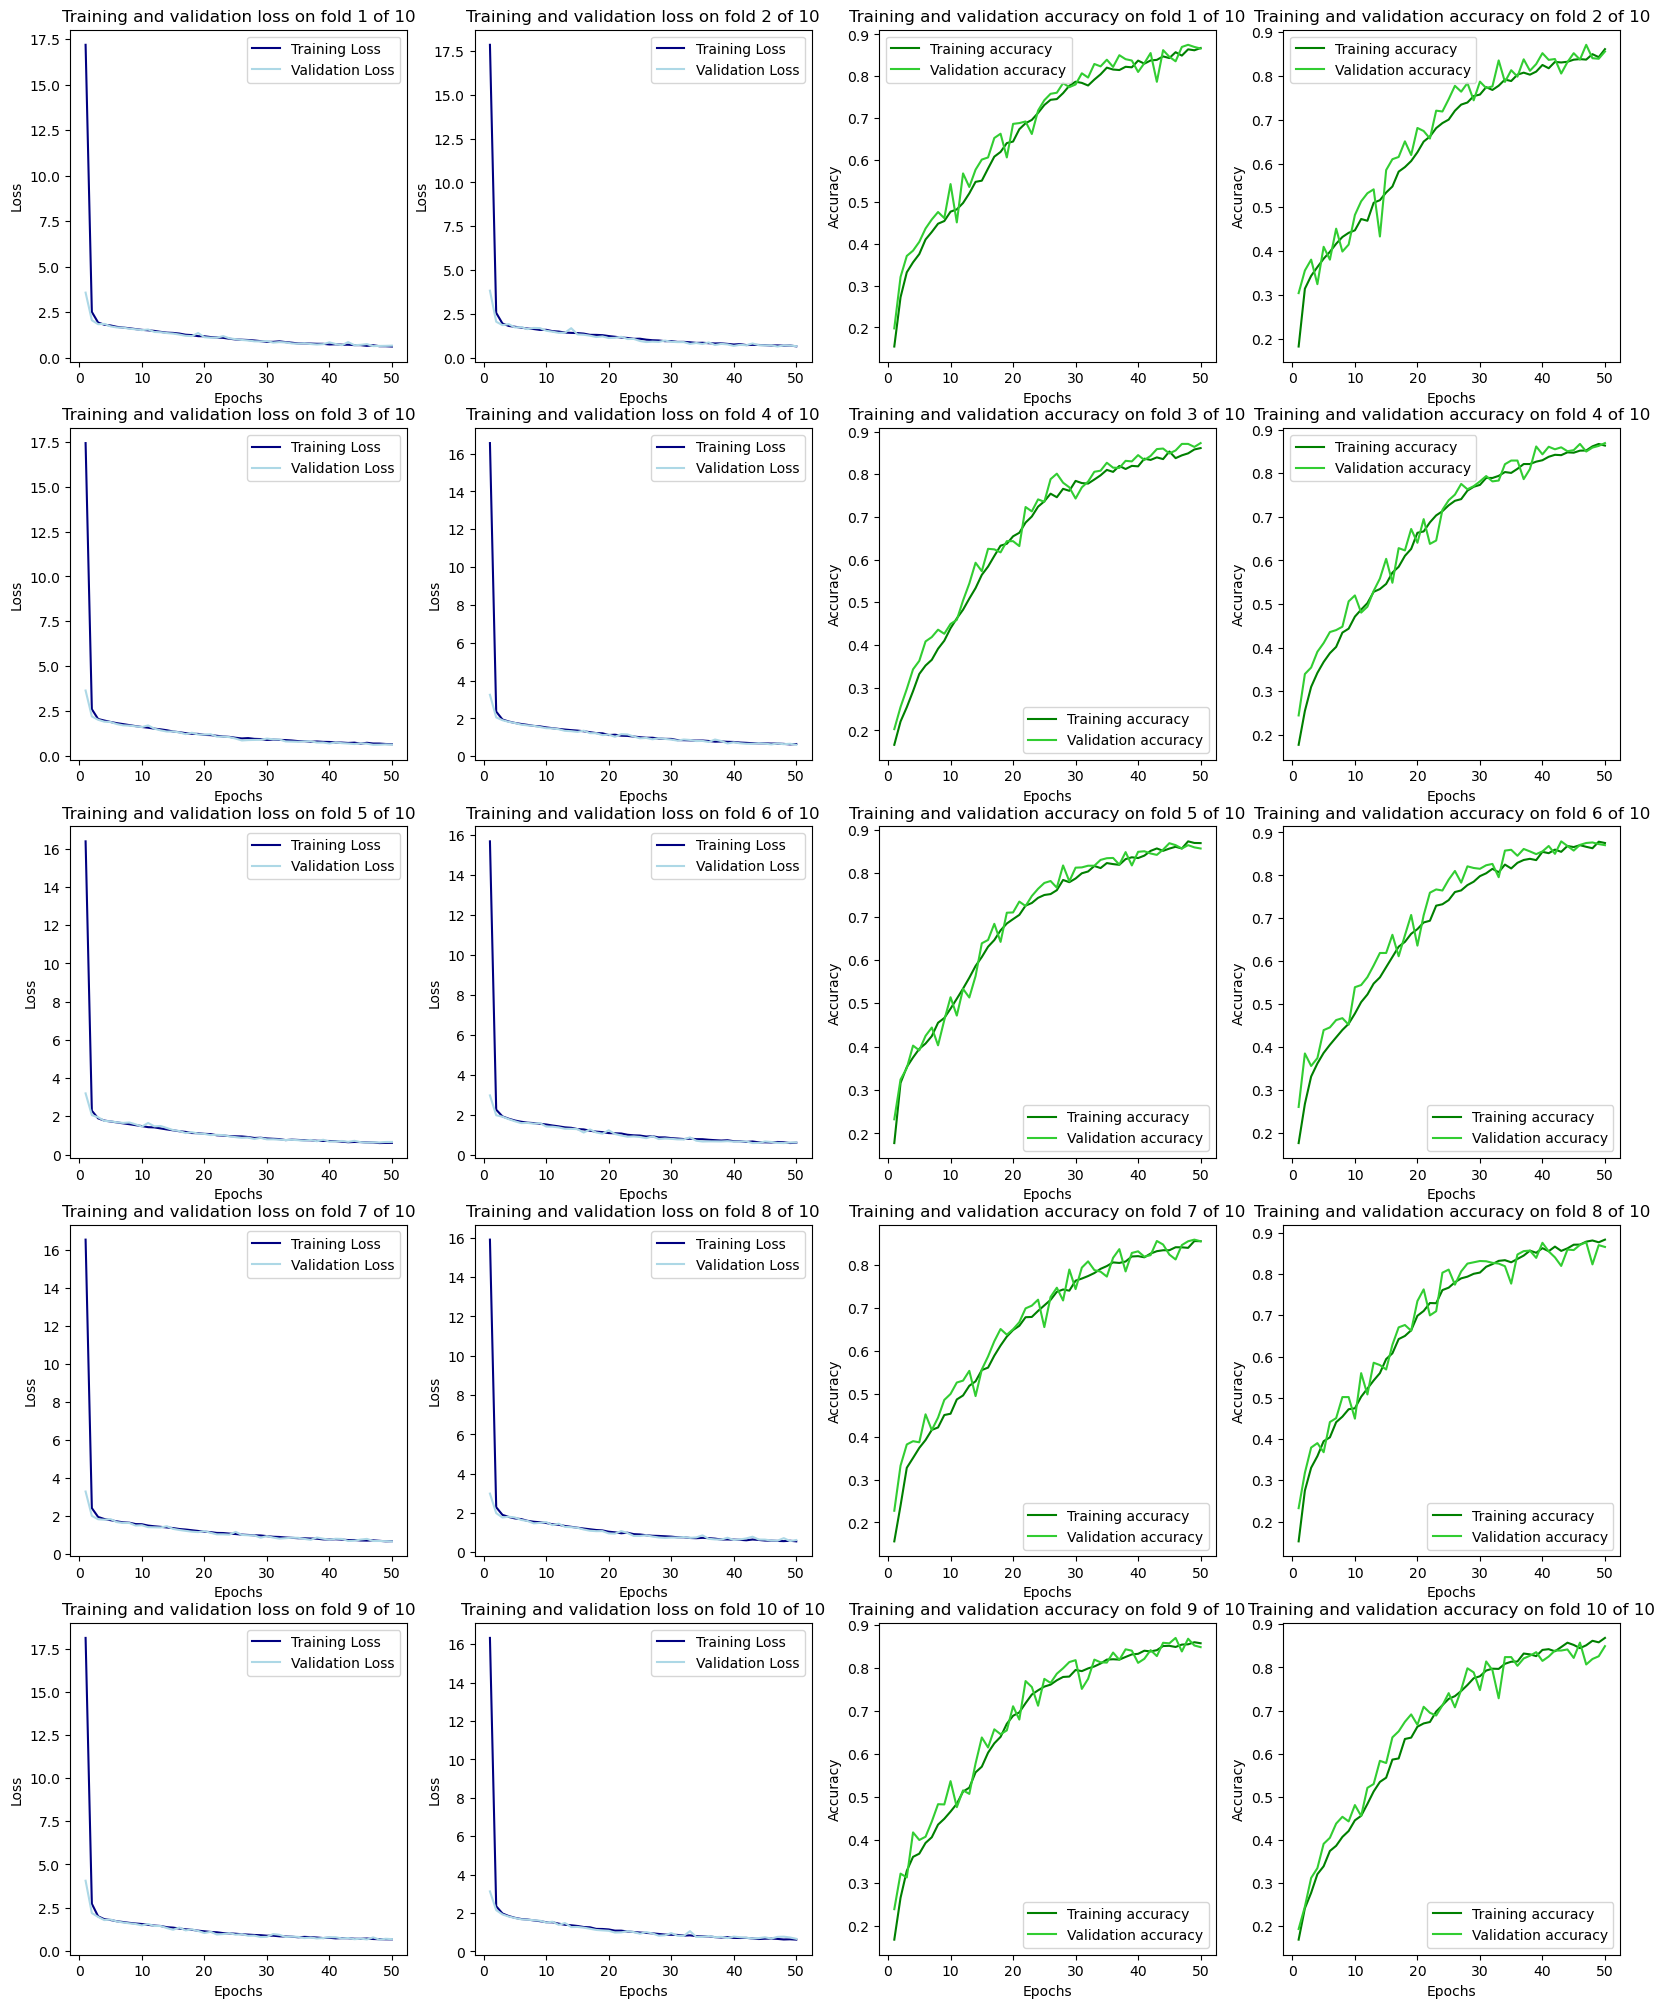

In [13]:
epochs = range(1, 101)

fig, ax = plt.subplots(5,4,figsize=(20,2.5*len(results)))

line = 0
for i in range(0,len(results), 2):
    
    epochs1 = results[i].get('num_epochs')
    epochs1 = list(range(1,epochs1+1))
    train_loss_values1=results[i].get('train_loss')
    train_acc_values1=results[i].get('train_accuracy')
    val_loss_values1 = results[i].get('val_loss')
    val_acc_values1 = results[i].get('val_accuracy')

    epochs2 = results[i+1].get('num_epochs')
    epochs2 = list(range(1,epochs2+1))
    train_loss_values2=results[i+1].get('train_loss')
    train_acc_values2=results[i+1].get('train_accuracy')
    val_loss_values2 = results[i+1].get('val_loss')
    val_acc_values2 = results[i+1].get('val_accuracy')

    ax[line,0].plot(epochs1,train_loss_values1, color='navy', linestyle='-',label='Training Loss')
    ax[line,0].plot(epochs1,val_loss_values1,color='lightblue', linestyle='-', label='Validation Loss')
    ax[line,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[line,0].set_xlabel('Epochs')
    ax[line,0].set_ylabel('Loss')
    ax[line,0].legend()

    ax[line,1].plot(epochs2,train_loss_values2,color='navy', linestyle='-',label='Training Loss')
    ax[line,1].plot(epochs2,val_loss_values2,color='lightblue', linestyle='-', label='Validation Loss')
    ax[line,1].set_title('Training and validation loss on fold '+str(i+2)+' of 10')
    ax[line,1].set_xlabel('Epochs')
    ax[line,1].set_ylabel('Loss')
    ax[line,1].legend()
    
    ax[line,2].plot(epochs1,train_acc_values1,color='green', linestyle='-', label='Training accuracy')
    ax[line,2].plot(epochs1,val_acc_values1,color='limegreen', linestyle='-', label='Validation accuracy')
    ax[line,2].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[line,2].set_xlabel('Epochs')
    ax[line,2].set_ylabel('Accuracy')
    ax[line,2].legend()
    
    ax[line,3].plot(epochs2,train_acc_values2,color='green', linestyle='-', label='Training accuracy')
    ax[line,3].plot(epochs2,val_acc_values2,color='limegreen', linestyle='-', label='Validation accuracy')
    ax[line,3].set_title('Training and validation accuracy on fold '+str(i+2)+' of 10')
    ax[line,3].set_xlabel('Epochs')
    ax[line,3].set_ylabel('Accuracy')
    ax[line,3].legend()

    line += 1

plt.show()

Estes gráficos representam a evolução da loss (azuis) e accuracy (verdes) nos sets de treino (escuros) e validação (claros).

Tal como no modelo MLP, podemos analisar que, para todos os folds, enquanto se dá um **decréscimo da training loss ao longo das epochs, o mesmo acontece com o validation loss.** Enquanto que no MLP este decréscimo se dava de forma gradual, neste caso vemos uma descida bastante mais abrupta, que estabiliza a partir do quinto epoch e desce com menos declive a partir daí.<br>
Esta tendência mostra que o nosso modelo está a aprender muito bem e a generalizar bastante corretamente. Ótimo!

Quanto à accuracy, vê-se que, **com a passagem das epochs, quer a training accuracy como a validation accuracy aumentam.** Tem-se, portanto, uma aprendizagem consistente com um ótimo fit!

###### 

###### &emsp;&emsp;&emsp;&emsp;Tempo de Treino, Número de Epochs e Testing Accuracy

In [14]:
tempos_lst=[]
epochs_lst = []
accuracies_lst=[]

for i in range(0, len(results)):
    tempos_lst.append(results[i].get('time'))
    epochs_lst.append(results[i].get('num_epochs'))
    accuracies_lst.append(results[i].get('test_accuracy'))

print("\nTempo:")
print(f"Max - {round(max(tempos_lst),2)} segundos na fold {np.argmax(tempos_lst)+1}")
print(f"Min - {round(min(tempos_lst),2)} segundos na fold {np.argmin(tempos_lst)+1}")

print("\nAccuracy:")
print(f"Max - {round(max(accuracies_lst)*100,2)} na fold {np.argmax(accuracies_lst)+1}")
print(f"Min - {round(min(accuracies_lst)*100,2)} na fold {np.argmin(accuracies_lst)+1}")

visao_geral_fold = {
    ' ': ['Fold1', 'Fold2', 'Fold3', 'Fold4',' Fold5', 'Fold6', 'Fold7', 'Fold8', 'Fold9', 'Fold10'],
    'Epochs':[epochs_lst[0], epochs_lst[1], epochs_lst[2], epochs_lst[3], epochs_lst[4], epochs_lst[5], epochs_lst[6], epochs_lst[7], epochs_lst[8], epochs_lst[9]],
    'Training Time (s)': [tempos_lst[0], tempos_lst[1], tempos_lst[2], tempos_lst[3], tempos_lst[4], tempos_lst[5], tempos_lst[6], tempos_lst[7], tempos_lst[8], tempos_lst[9]],
    'Testing Accuracy (%)': [accuracies_lst[0]*100, accuracies_lst[1]*100, accuracies_lst[2]*100, accuracies_lst[3]*100, accuracies_lst[4]*100, accuracies_lst[5]*100, accuracies_lst[6]*100, accuracies_lst[7]*100, accuracies_lst[8]*100, accuracies_lst[9]*100]
}

df = pd.DataFrame(visao_geral_fold)
df


Tempo:
Max - 961.57 segundos na fold 1
Min - 872.82 segundos na fold 10

Accuracy:
Max - 73.08 na fold 5
Min - 56.38 na fold 6


,,Epochs,Training Time (s),Testing Accuracy (%)
0,Fold1,50,961.570020,68.499428
1,Fold2,50,930.271518,61.936939
2,Fold3,50,916.442772,59.675676
3,Fold4,50,922.323299,60.707068
4,Fold5,50,955.709598,73.076922
5,Fold6,50,884.779131,56.379104
6,Fold7,50,873.583617,69.570404
7,Fold8,50,897.675361,62.903225
8,Fold9,50,875.819666,70.833331
9,Fold10,50,872.821241,71.206689


A primeira conclusão que podemos tirar ao olhar para esta tabela é que mesmo com um número de epochs bastante reduzido, os **folds necessitaram de bastante mais tempo para treinar** do que no MLP.<br>
Podemos, também, ver que o **training time entre folds não varia muito**.

Quanto à testing accuracy, vemos uma **grande melhoria** em comparação com o MLP. Chegamos a um **máximo de 73.08% de accuracy na fold 5** (aproximadamente mais 15% do que o MLP obteve nesta fold). A fold com menos accuracy foi a mesma que a no MLP (fold 6 com 56.38%, comparativamente com 42.53% no MLP).<br>
De modo geral, conseguimos uma melhora notável, e **nenhuma fold teve uma testing accuracy abaixo de 50%"!**

###### 

###### &emsp;&emsp;&emsp;&emsp; Confusion Matrixes

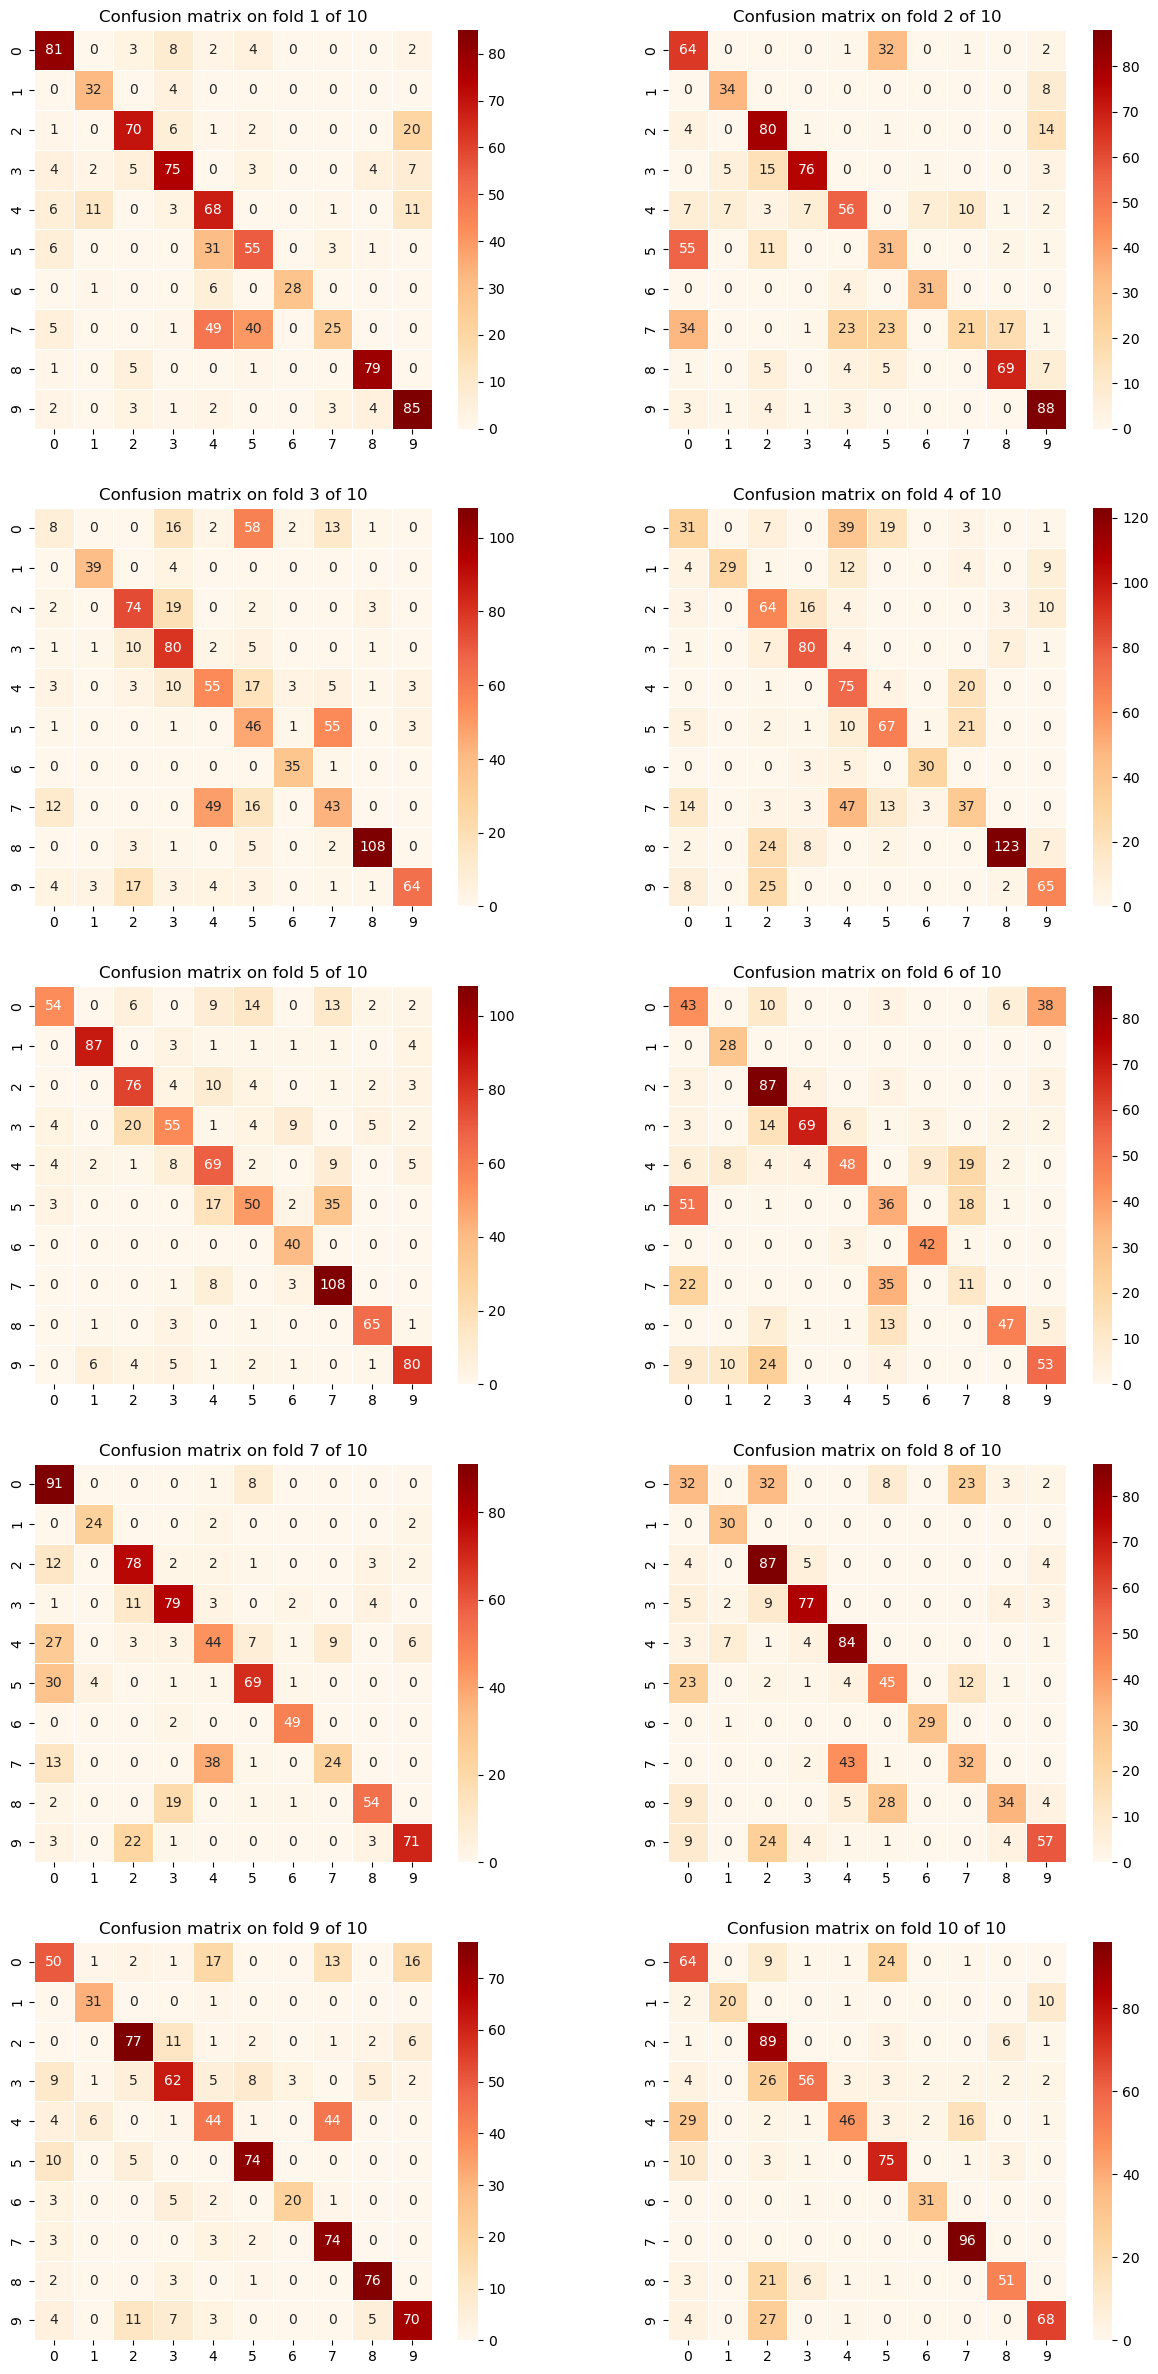

In [15]:
import seaborn as sns

fig, ax =plt.subplots(5, 2, figsize=(15,3*len(results)))

for i in range(0,len(results)):
    cm = results[i].get('confusion_matrix')
    ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'OrRd', ax=ax[i//2,i%2])

plt.show()


A existência de 10 folds torna **difícil a análise individual de cada confusion matrix.**<br>
De qualquer modo, é visível que, para cada fold, as classes com melhor taxa de previsão variam bastante! Podemos, sem quakquer dúvida, ver uma imensa melhoria se colocarmos estas confusion matrixes lado a lado com as do MLP.Veremos o resultado final da confusion matrix futuramente, que nos permitirá tirar conclusões mais acertadas.

### 

### Modelo Global

###### &emsp;&emsp;&emsp;&emsp;Training Time, Accuracy e Standard Deviation de Train, Validation e Test

In [16]:
print(f"Tempo total de treino = {round(np.sum(tempos_lst),2)} segundos")
print(f"Tempo médio de treino por fold = {round(np.mean(tempos_lst),2)} segundos")

train_lst = []
val_lst = []
test_lst = []

for i in results:
    train_lst.append(max(i.get('train_accuracy')))  
    val_lst.append(max(i.get('val_accuracy')))     
    test_lst.append(i.get('test_accuracy'))        


avg_train_acc = np.mean(train_lst)
std_train_acc = np.std(train_lst)
avg_val_acc = np.mean(val_lst)
std_val_acc = np.std(val_lst)
avg_test_acc = np.mean(test_lst)
std_test_acc = np.std(test_lst)


table_data = {
    ' ': ['Training', 'Validation', 'Test'],
    'Accuracy (%)': [
        round(avg_train_acc * 100, 2),  
        round(avg_val_acc * 100, 2),
        round(avg_test_acc * 100, 2)
    ],
    'Standard Deviation (%)': [
        round(std_train_acc * 100, 2),  
        round(std_val_acc * 100, 2),
        round(std_test_acc * 100, 2)
    ]
}


df = pd.DataFrame(table_data)
df

Tempo total de treino = 9091.0 segundos
Tempo médio de treino por fold = 909.1 segundos


,,Accuracy (%),Standard Deviation (%)
0,Training,86.77,0.82
1,Validation,87.01,0.67
2,Test,65.48,5.51


O nosso modelo teve um **tempo de treino total de aproximadamente 2 horas e 30 minutos**, demorando, em média, 15 minutos por fold.

Como resultado de **test accuracy final temos 65.48**, com 5.51% de standard deviation.<br>
Este resultado mostra uma **enorme melhoria** face à accuracy obtida no MLP. Um aumento de quase 15% na accuracy!! Ótimo :3

###### 

###### &emsp;&emsp;&emsp;&emsp;Confusion Matrix

<AxesSubplot:title={'center':'Confusion matrix: Sum of all folds'}>

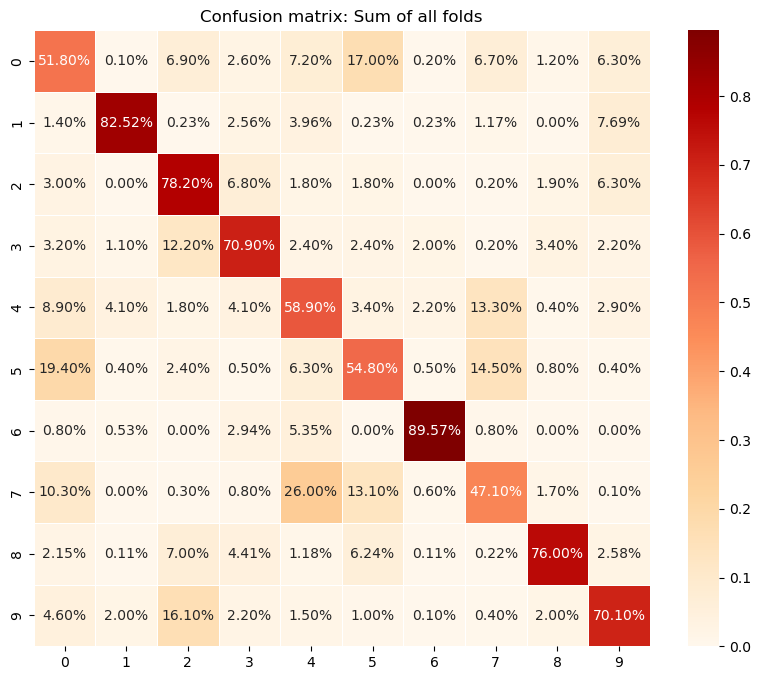

In [17]:
cm = np.zeros(shape=(10,10))
for i in results:
    cm += i.get('confusion_matrix')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax =plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Confusion matrix: Sum of all folds')
ax.invert_yaxis()
sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'OrRd', ax=ax)


Por fim, temos a confusion matrix de todas as folds juntas.

Como balanço geral temos um total de **9 classes com previsão correta superior a 50%** (classe 0 "air_conditioner", classe 1 "car_horn", classe 2 "children_playing", classe 3 "dog_bark", classe 4 "drilling", classe 5 "engine_idling", classe 6 "gun_shot", classe 8 "siren", classe 9 "street_music") e **apenas 1 classe com previsão correta inferior a 50%** (classe 7 "jackhammer").

A classe com **melhor taxa de previsão correta é a classe 6 "gun_shot" (89.57% seguida da classe 1 "car_horn" (82.52%); ambos valores elevados e um pouco próximos.<br>
Como classe com **pior taxa de previsão correta temos a classe 7 "jackhammer" (47.10%)**, seguida da classe 0 "air_conditioner" (51.80%); valores também próximos e não muito baixos!

Esta confusion matrix mostra imensas melhorias face à obtida no MLP. Conseguimos passar de 4 classes com previsão correta inferior a 50% para apenas 1 classe e todas as classes viram um aumento na sua taxa de previsão correta!

# 

# 6. Conclusões e Notas

Após esta análise de dados ficámos felizes com todos os resultados.

Tivemos um **enorme aumento na accuracy do modelo**, e o **padrão descoberto no modelo MLP foi bastante mitigado**. Sim o nosso modelo **ainda tem problemas em classificar os audios mais ruidosos**, mas esta abordagem convolucional mostrou-se bastante **mais eficaz**. 

Infelizmente, este modelo tem um **grande problema**: a sua **complexidade**.<br>
Um modelo tão "pesado" leva a **tempos de treino bastante grandes**, e exige uma **grande dedicação do computador**. Este notebook foi executado num computador sem placa gráfica dedicada e, estando o tensorflow optimizado para placas gráficas NVidia, este processo tornou-se bastante mais problemático, pois teve de usar as capacidades gráficas do CPU.<br>
Sobreaquecmento, mortes de kernel e dificuldades de optimização foram apenas alguns dos vários obstáculos que enfrentamos. De todo o modo, estes problemas levaram a um **modelo mais cauteloso no que toca ao uso de CPU!** E, acima de tudo, um **bom modelo!**

Para concluir, tinhamos um problema de accuracy no modelo anterior (como seria de esperar), apresentamos uma solução, e a sua execução mostrou os resultados desejados (também como seria de esperar).

Achamos que este modelo encontra-se bastante bem estruturado e, de modo a desenvolver um modelo mais capaz seria necessário mais tempo e mais recursos. Como tal, estes resultados atingem as espectativas que definimos n início do trabalho, a todos os níveis!